# Project 2 

### Introduction

In this project we will solve a 2D advection-diffusion problem given by

\begin{equation}
    \begin{aligned}
        -\Delta u + \mathbf{v} \cdot \nabla u &= f, \quad &&0 \leq x,y \leq 1 \\
        u &= g,  \quad &&\text{on the boundary.}
    \end{aligned}
    \tag{1}
\end{equation}

To solve this problem we will use three different methods;  GMRES, multigrid V-cycle, and a preconditioned GMRES method using the multigrid V-cycle as a preconditioner. For simplicity, we assume that the velocity field $\mathbf{v} = [v_1, v_2]^T \geq \mathbf{0}$, in the sence that $v_1, v_2 \geq 0$. We also use an equidistant grid with stepsize $h = \frac{1}{N}$, such that $u_{i,j} = u(x_i,y_j) = u(ih,jh)$ and similarly for $f_{i,j}$. For the discretization of the problem we use a 5-point stencil for the diffusion term and an upwind scheme for the advection term, hence we get the following formula

\begin{equation}
    \begin{aligned}
        (4U_{i,j}- U_{i+1,j} - U_{i-1,j} -U_{i,j+1} -U_{i,j-1}) + hv_1(U_{i,j} - U_{i-1,j}) + hv_2(U_{i,j} - U_{i,j-1}) =  h^2f_{i,j}.
    \end{aligned}
    \tag{2}
\end{equation}

For simplicity we choose $\mathbf{v} = [1,1]$ and an excact solution $u(x,y) = \sin(\pi x)\sin(2\pi y)$. By balancing the equation using (1) we get that the right hand sides becomes 

\begin{equation}
    \begin{aligned}
       f(x,y) &= -\Delta u + \mathbf{v} \cdot \nabla u = 5\pi^2 \sin(\pi x)\sin(2\pi y) + \pi \cos(\pi x)\sin(2\pi y) + 2\pi \sin(\pi x)\cos(2\pi y) \\
       g &= 0
    \end{aligned}
    \tag{3}
\end{equation}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, LinearOperator
from time import perf_counter

### Task (0)

Now we try and solve the problem for different values of $N$ on the grid, for a random guess U

In [22]:
def lhs_func(U, N, v=np.array([1, 1])):
    """Computes the left-hand side vector based on the input array U for diffusion-advection problem."""
    h = 1 / N
    U = np.reshape(U, (N+1,N+1))
    lhs = np.zeros((N + 1, N + 1))     # Initialize LHS with zeros 
    for i in range(1, N):               # Skip boundaries
        for j in range(1, N):
            lhs[i, j] = (4 * U[i, j] - U[i + 1, j] - U[i-1, j] - U[i, j + 1] - U[i, j - 1]
                          + v[0] * h * (U[i, j] - U[i-1, j]) + v[1] * h * (U[i, j] - U[i, j-1]))
    return lhs

In [24]:
def rhs_func(N, v=np.array([1, 1])):
    """Constructs the right-hand side vector f based on the analytical solution."""
    h = 1 / N
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, -y)
    
    # Analytical function for f based on the exact solution u(x, y) = sin(pi x) * sin(2 * pi y)
    f = np.pi*(5 * np.pi * np.sin(np.pi * X) * np.sin(2 * np.pi * Y) +
            v[0] * np.cos(np.pi * X) * np.sin(2 * np.pi * Y) +
            v[1] * 2*np.sin(np.pi * X) * np.cos(2 * np.pi * Y))

    f[:, 0] = 0  # Left boundary
    f[:, -1] = 0  # Right boundary
    f[0, :] = 0  # Bottom boundary
    f[-1, :] = 0  # Top boundary

    # Scale by h^2 as per the finite difference scheme
    return (h ** 2) * f

In [44]:

def solve_scipy_gmres(U0, N, v=np.array([1, 1]), tol=1e-10):
    """Solve the diffusion-advection problem using GMRES for a grid of size (N+1) x (N+1)."""
    x0 = U0.flatten()  # Flatten the initial guess
    A = LinearOperator((x0.size, x0.size), matvec=lambda u_flat: lhs_func(u_flat.reshape((N+1, N+1)), N, v).flatten())
    # Compute the right-hand side using rhs_func and flatten it to a 1D vector
    b = rhs_func(N, v).flatten()  # A (N+1)^2 vector for the rhs
    u_flat, exitCode = gmres(A, b, x0=x0, tol=tol)
    if exitCode != 0:
        print("GMRES did not converge")
    return u_flat.reshape((N+1, N+1))


In [8]:
def u_exact(N):
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, -y)
    
    # Compute the exact solution at each grid point
    u_exact = np.sin(np.pi * X) * np.sin(2 * np.pi * Y)
    
    return u_exact

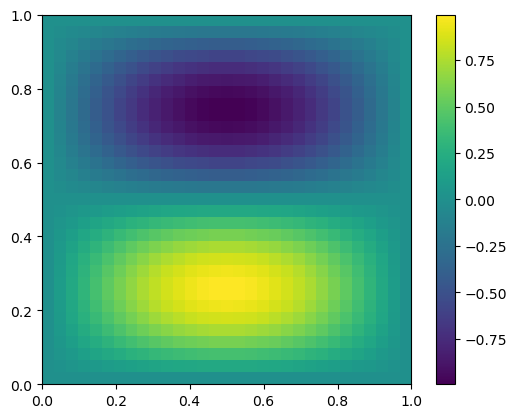

In [9]:
u_ex = u_exact(30)
plt.imshow(u_ex, extent = [0,1,0,1])
plt.colorbar()


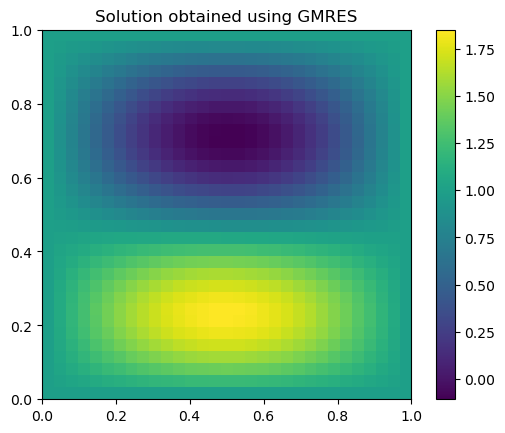

In [46]:
N = 30
U0 = np.ones((N+1,N+1))  # Random initial guess
u = solve_scipy_gmres(U0, N, v=np.array([1, 1]), tol=1e-10)


# Plot the result
plt.imshow(u, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Solution obtained using GMRES")
plt.show()

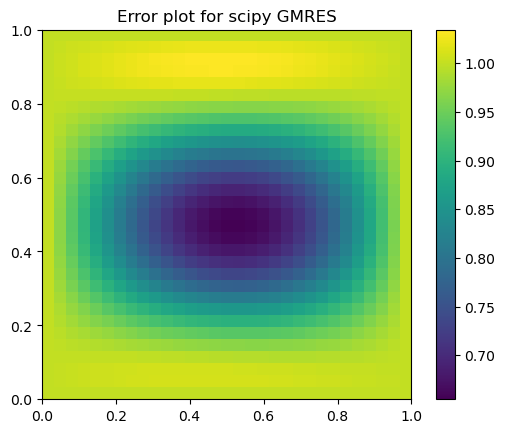

In [48]:
error = u - u_ex
plt.imshow(error, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Error plot for scipy GMRES")
plt.show()

### Task (1)

Firstly we create a orthonormal basis for the Krylov subspace using Arnoldi's method

In [50]:
# Arnoldi function
def arnoldi( m, N, omega, v=np.array([1, 1])):
    """
    Arnoldi's method to generate an orthonormal basis for the Krylov subspace
    
    Parameters:
        U0: Initial guess matrix
        v: The starting vector
        k: The number of basis vectors to compute.
        N: Grid size
        omega: Initial residual or starting vector
    
    Returns:
        V: The orthonormal basis vectors
        H: The upper Hessenberg matrix 
    """
    n = (N+1)**2  # Total number of grid points including boundary
    V = np.zeros((n, m+1))  # Orthonormal basis
    H = np.zeros((m+1, m))  # Upper Hessenberg matrix with k+1 rows
    
    # Normalize the first vector
    V[:,0] = omega / np.linalg.norm(omega)
    for j in range(m):
        # Compute the next vector using lhs_func to apply the operator
        w = lhs_func(V[:, j], N, v).flatten()  # Apply the operator to the vector V[:, j]
        # Orthogonalization against previous vectors
        for i in range(j+1):
            H[i, j] = np.dot(V[:, i], w)
            w -= H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(w)
        if np.abs(H[j+1,j]) <= 1.e-12:
            print("H[j+1,j] is close to 0")            
            break
        V[:,j+1] = w/H[j+1,j]
    return V, H 



In [64]:
# Restarted GMRES method
def restarted_gmres(U0, m, N, tol=1e-4, v=np.array([1, 1])):
    """
    Restarted GMRES method using Arnoldi's method to solve Ax = b.

    Parameters:
        U0: The initial guess matrix 
        m: Number of iterations before restart.
        tol: Convergence tolerance.
        N: Grid size
        v: Advection speed
    
    Returns:
        x: The computed solution vector
        count: Number of iterations
        time: Converging time
    """
    start = perf_counter()
    x = U0.copy().flatten()      #Initial guess vector
    b = rhs_func(N, v).flatten()  # Right-hand side vector
    r_0 = b - lhs_func(x, N, v).flatten()  #Error matrix
    norm_r0 = np.linalg.norm(r_0)
    
    if norm_r0 < tol:  # Already converged
        return x, 0, 0
    
    beta = norm_r0
    omega_1 = r_0 / beta  # Normalize the initial residual
    count = 0
    
    while True:
        V, H = arnoldi(m, N, omega=omega_1, v=v)  # Create an Arnoldi basis
        try:
            y = np.linalg.solve(H, np.dot(V.T, b - lhs_func(x, N, v).flatten())) 
        except np.linalg.LinAlgError:
            y = np.linalg.pinv(H) @ np.dot(V.T, b - lhs_func(x, N, v).flatten())  #Use the moore penrose inverse if H is singular
        x += V[:, :y.size] @ y  # Only use the relevant part of V and y
        r_m = b - lhs_func(x, N, v).flatten()  # New residual
        count += 1
        
        if np.linalg.norm(r_m) / norm_r0 < tol:  # Check convergence
            break
        
        # Prepare for the next restart
        r_0 = r_m  # Update the residual for the next iteration
        beta = np.linalg.norm(r_0)
        omega_1 = r_0 / beta  # Normalize the new residual
    
    stop = perf_counter()
    time = stop - start
    return x.reshape((N+1, N+1)), count, time  # Reshape the solution into (N+1)x(N+1) grid

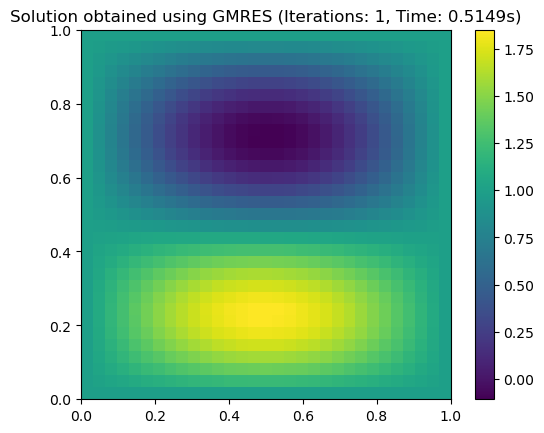

In [66]:
# Example usage
N = 30  # Grid size
U0 = np.ones((N+1, N+1))  # Random initial guess
u, count, time = restarted_gmres(U0, 50, N, tol=1e-4)

# Plot the result
plt.imshow(u, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title(f"Solution obtained using GMRES (Iterations: {count}, Time: {time:.4f}s)")
plt.show()

### Task (2)

First define the jacobi iteration, residual, restriction and interpolation functions.

In [80]:
def jacobi_relax(u, rhs, omega, N, nu, v):
    """
    Perform weighted Jacobi iterations with upwind differencing for advection.
    
    Parameters:
        u: Initial guess (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        omega: Relaxation parameter.
        N: Grid size.
        nu: Number of Jacobi iterations.
        v: Velocity field [v_x, v_y].
        
    Returns:
        Updated solution u after nu iterations.
    """
    h = 1 / N
    index = np.arange(1, N)  # Indices corresponding to internal nodes
    ixy = np.ix_(index, index)
    ixm_y = np.ix_(index - 1, index)  # i-1, j
    ixp_y = np.ix_(index + 1, index)  # i+1, j
    ix_ym = np.ix_(index, index - 1)  # i, j-1
    ix_yp = np.ix_(index, index + 1)  # i, j+1
    
    div = (4 + v[0] * h + v[1] * h) # Denominator includes advection terms
    for k in range(nu):
        u_new = u.copy()  # Create a copy to avoid overwriting in the same iteration
        # Jacobi iteration with upwind differencing for advection
        u_new[ixy] = ((1 - omega) * u[ixy] + 
                     omega*( (u[ixp_y] + u[ixm_y] * (1 + v[0] * h) + 
                      u[ix_yp] + u[ix_ym] * (1 + v[1] * h))/div + (rhs[ixy]/div) ))
        u = u_new  #Update the solution
    return u

def mgv_lhs_func(U, v = np.array([1,1])):
    """Computes the left-hand side vector based on the input array U for a diffusion-advection problem."""
    # Check if U is 1D or 2D and reshape if necessary
    if U.ndim == 1:
        N = int(np.sqrt(U.size)) - 1  # Infer N from the size of U
        U = np.reshape(U, (N + 1, N + 1))  # Reshape to (N+1, N+1)
    elif U.ndim == 2:
        N = U.shape[0] - 1  # Infer N from the shape of U
    else:
        raise ValueError("Input array U must be either 1D or 2D.")
    
    # Grid spacing
    h = 1 / N
    lhs = np.zeros((N + 1, N + 1))  # Initialize LHS with zeros

    # Compute the LHS values for internal points (excluding boundaries)
    for i in range(1, N):  # Skip boundaries
        for j in range(1, N):
            lhs[i, j] = (4 * U[i, j] - U[i + 1, j] - U[i - 1, j] - U[i, j + 1] - U[i, j - 1]
                          + v[0] * h * (U[i, j] - U[i - 1, j]) + v[1] * h * (U[i, j] - U[i, j - 1]))
    
    return lhs
    
def residual(u, rhs, N):
    """
    Compute the residual r = rhs - A @ u, where A is the discretized operator.
    
    Parameters:
        u: Current solution (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        N: Grid size.
        
    Returns:
        Residual matrix.
    """
    r = np.zeros_like(u)
    h = 1/N
    r = rhs -  mgv_lhs_func(u, v = np.array([1,1]))
    return r

def restriction(r, N):
    """
    Restrict the residual to a coarser grid using full-weighting.
    
    Parameters:
        r: Residual matrix (N+1)x(N+1).
        N: Grid size of the fine grid.
        
    Returns:
        Restricted residual on the coarser grid.
    """
    Nc = N // 2
    rc = np.zeros((Nc + 1, Nc + 1))
    for i in range(1, Nc):
        for j in range(1, Nc):
            rc[i, j] = (1/4) * (r[2*i, 2*j] + r[2*i-1, 2*j] + r[2*i, 2*j-1] + r[2*i-1, 2*j-1])
    return rc

def interpolation(e, N):
    """
    Interpolate the error from the coarse grid to the fine grid using linear interpolation.
    
    Parameters:
        e: Error matrix (N/2+1)x(N/2+1).
        N: Grid size of the fine grid.
        
    Returns:
        Interpolated error matrix on the fine grid.
    """
    nf = N + 1
    ef = np.zeros((nf, nf))
    for i in range(1, N // 2):
        for j in range(1, N // 2):
            ef[2*i, 2*j] += e[i, j]
            ef[2*i-1, 2*j] += 0.5 * e[i, j]
            ef[2*i, 2*j-1] += 0.5 * e[i, j]
            ef[2*i-1, 2*j-1] += 0.25 * e[i, j]
    return ef

Make the multigrid V-cycle function

In [96]:
def mgv(u0, rhs, v, N, nu1, nu2, level, max_level):
    """
    Perform one multigrid V-cycle on the 2D advection-diffusion equation.

    Parameters:
        u0: Initial guess (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        v: Velocity field (not used in the given context).
        N: Grid size.
        nu1: Number of pre-smoothings.
        nu2: Number of post-smoothings.
        level: Current level of the V-cycle.
        max_level: Total number of levels.
        
    Returns:
        u: The computed solution vector
        count: Number of iterations
        time: Converging time
        
    """
    start = perf_counter()
    count = 0
    if level == max_level or N <10:
        # On the coarsest level, solve using GMRES
        u = restarted_gmres(U0, max_level, N//2**max_level, tol=1e-4, v=np.array([1, 1]))
        return u
    else:
        u = jacobi_relax(u0, rhs, 2/3, N, nu1,v) # Pre-smoothing
        rf = residual(u, rhs, N)         # Compute the residual
        rc = restriction(rf, N)          # Restrict the residual to a coarser grid
        count +=1 
        ec = mgv(np.zeros_like(rc), rc, v, N // 2, nu1, nu2, level + 1, max_level)   #Recursive call on the coarser grid
        ef = interpolation(ec, N // 2)   # Interpolate the error back to the fine grid
        u += ef                          # Update the solution with the interpolated error
        u = jacobi(u, rhs, 2/3, N, nu2)  # Post-smoothing
    stop = perf_counter()
    time = stop - start
    return u, count, time

### Task (3)

Solve a problem

In [100]:
#Problems with the grid sizes in the lhs_func when the mgv function is called recursively

u0 = np.zeros((N+1,N+1))
rhs = rhs_func(N, v=np.array([1, 1]))
v = np.array([1,1])

u_mgv, count_mgv, time_mgv = mgv(u0, rhs, v, N = 100, nu1 = 10, nu2 = 10, level = 1, max_level= 5)

IndexError: index 31 is out of bounds for axis 0 with size 31

### Task (4) 

Need to change the vector product Ax with the lhs_func.

In [ ]:
def precon_gmres(A, b, x0, restart_k, nu1, nu2, max_level, tol=1e-4):
    """
    Preconditioned GMRES method using Arnoldi's method to solve Ax = b.

    Parameters:
        A: The input matrix (n x n).
        b: The right-hand side vector (n x 1).
        x0: Initial guess for the solution (n x 1).
        restart_k: Number of iterations before restart.
        nu1: Number of pre-smoothings for multigrid.
        nu2: Number of post-smoothings for multigrid.
        max_level: Maximum levels for multigrid.
        tol: Convergence tolerance.
    
    Returns:
        x: The computed solution vector
        count: NUmber of iterations
        time: Converging time
        
    """
    start = perf_counter() 
    n = A.shape[0]
    x = x0.copy()
    r_0 = b - A.dot(x)
    norm_r0 = np.linalg.norm(r_0)
    count = 0
    
    if norm_r0 < tol:  # Already converged
        return x
    beta = norm_r0
    v_1 = r_0 / beta  # Normalize the initial residual
    while True:
        V, H = arnoldi(A, v_1, restart_k) # Perform Arnoldi process to create an orthonormal basis
        z = mgv(np.zeros((N+1,N+1)), rhs, v, N, nu1, nu2, level, max_level).flatten() # Compute the preconditioned residual
        y = np.linalg.solve(H, np.dot(V.T, z))  # Solve the least squares problem using the preconditioned residual
        x += V @ y  #Update the solution
        r_k = b - A.dot(x)  #New residual
        count +=1
        # Check convergence
        if np.linalg.norm(r_k) / norm_r0 < tol:
            break
        # Prepare for the next restart
        r_0 = r_k  # Update the residual for the next iteration
        beta = np.linalg.norm(r_0)
        v_1 = r_0 / beta  # Normalize the new residual
    stop = perf_counter() 
    time = stop - start
    return x, count, time
